# Fifth Task: Explanation

### Import of the needed libraries

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import dice_ml

from tensorflow.keras.models import load_model
from IPython.display import Image
from sklearn import tree  
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import permutation_importance
from joblib import dump, load
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.blackbox import LimeTabular
from interpret import show
from xailib.explainers.lore_explainer import LoreTabularExplainer
from tqdm import tqdm

### Import of the dataset and preparing for explanation

In [368]:
data_merged = pd.read_csv('./dataset/data_merged.csv')

# Training set
train_data = data_merged[data_merged['date'] < 2022]
# Test set
test_data = data_merged[data_merged['date'] >= 2022]

# Feature and target for training
train_feature = train_data.drop("top_20", axis="columns").select_dtypes(include="number")
train_target = train_data['top_20']

# Feature and target for testing
test_feature = test_data.drop("top_20", axis="columns").select_dtypes(include="number")
test_target = test_data['top_20']

# Feature names
columns = train_data.columns.tolist()
columns.remove('top_20')

# Full dataset
full_dataset = pd.concat([train_feature, test_feature])

## Utility functions

In [369]:
def plot_feature_importance(model, feature_names):
    """
    Calculate and plot feature importance for a model.

    Parameters:
    - model: Trained model.
    - feature_names: List of feature names corresponding to the input data.
    """
    # Extract feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()


### Decision Tree

In [370]:
# Import the model
dt = load('./models/decision_tree.joblib')

#### Feature importance

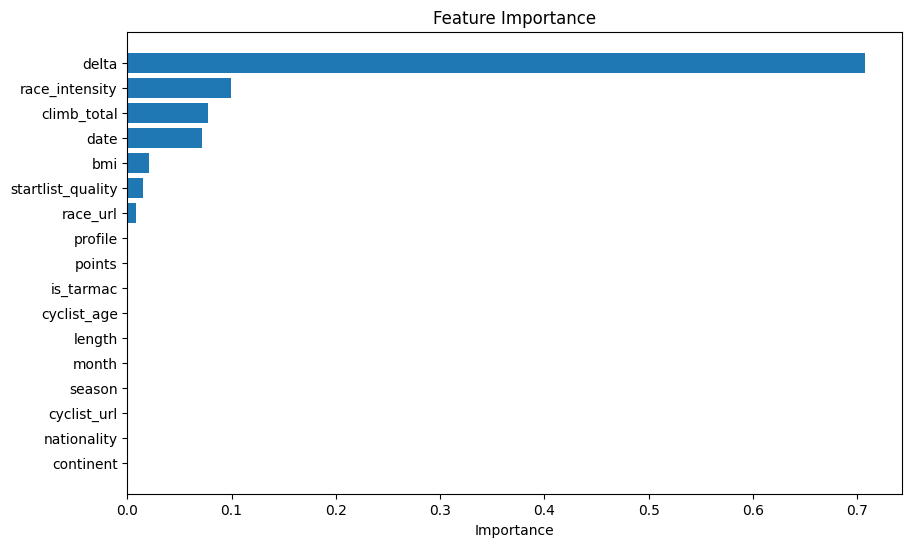

In [371]:
# Plot feature importance
plot_feature_importance(dt, test_feature.columns)

Use of shap

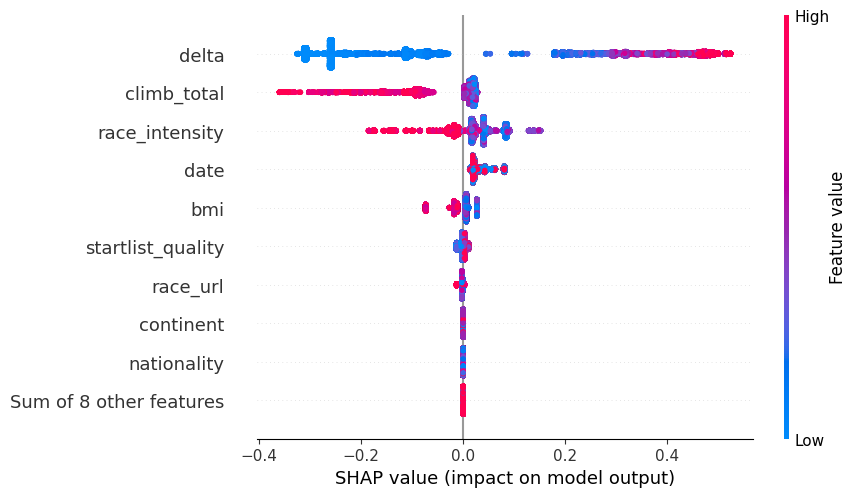

In [372]:
interventional_explanation_algorithm_dt = shap.TreeExplainer(
    model=dt,
    data=train_feature,         # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm_dt = shap.TreeExplainer(
    model=dt,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

interventional_explanations_dt = interventional_explanation_algorithm_dt(test_feature)
distributional_explanations_dt = distributional_explanation_algorithm_dt(test_feature)

shap.plots.beeswarm(interventional_explanations_dt[:, :, 0])

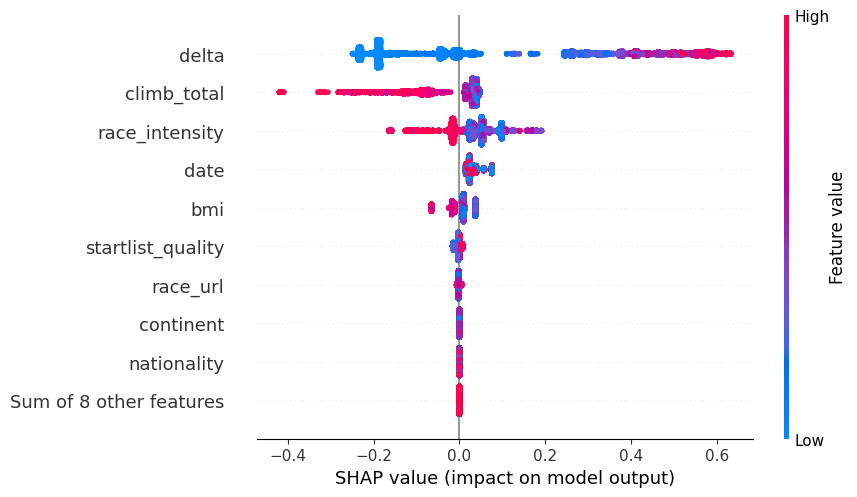

In [373]:
shap.plots.beeswarm(distributional_explanations_dt[:, :, 0])

<Axes: ylabel='Density'>

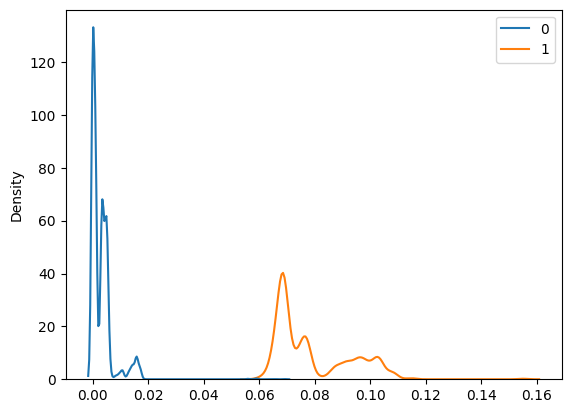

In [374]:
explanation_differences_dt = interventional_explanations_dt.values - distributional_explanations_dt.values

maximum_differences_per_instance_dt = explanation_differences_dt.max(axis=1)
sns.kdeplot(maximum_differences_per_instance_dt)

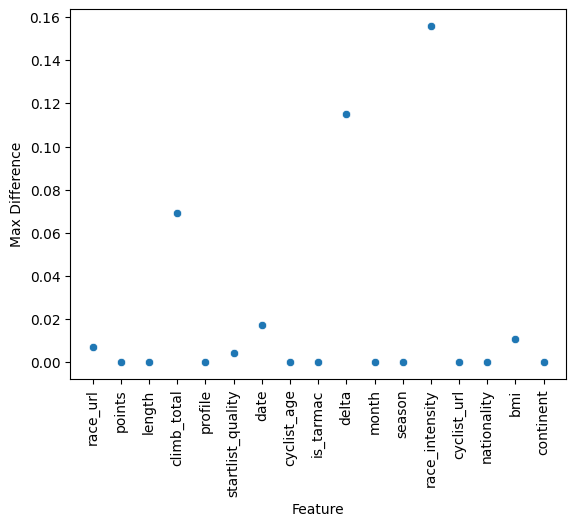

In [375]:
maximum_differences_per_feature_dt = explanation_differences_dt.max(axis=0)

feature_importances_dt = pd.DataFrame({
    'Feature': columns,
    'Max Difference': maximum_differences_per_feature_dt.max(axis=1)
})

sns.scatterplot(x='Feature', y='Max Difference', data=feature_importances_dt)
plt.xticks(rotation=90)
plt.show()

In [376]:
interventional_explanations_df_dt = pd.DataFrame(interventional_explanations_dt[:, :, 0].values, columns=columns)
interventional_explanations_df_dt.describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,-0.001825,0.0,0.0,-0.030780,0.0,-0.000940,0.028993,0.0,0.0,0.058164,0.0,0.0,0.020152,0.0,0.0,-0.001240,0.0
std,0.002369,0.0,0.0,0.073041,0.0,0.005502,0.017324,0.0,0.0,0.285378,0.0,0.0,0.048264,0.0,0.0,0.023873,0.0
min,-0.012775,0.0,0.0,-0.360058,0.0,-0.014522,0.012843,0.0,0.0,-0.325749,0.0,0.0,-0.185821,0.0,0.0,-0.073463,0.0
25%,-0.002566,0.0,0.0,-0.085870,0.0,-0.002564,0.018896,0.0,0.0,-0.257414,0.0,0.0,-0.010334,0.0,0.0,-0.011670,0.0
50%,-0.001796,0.0,0.0,0.009808,0.0,-0.001888,0.021460,0.0,0.0,-0.062084,0.0,0.0,0.020298,0.0,0.0,0.003890,0.0
75%,-0.000307,0.0,0.0,0.018727,0.0,0.002564,0.030888,0.0,0.0,0.320112,0.0,0.0,0.041153,0.0,0.0,0.005985,0.0
max,0.002345,0.0,0.0,0.028132,0.0,0.010257,0.081583,0.0,0.0,0.523983,0.0,0.0,0.151503,0.0,0.0,0.026632,0.0


Analizziamo race_intensity, bisogna capire meglio come funziona

<Axes: xlabel='race_intensity', ylabel='Density'>

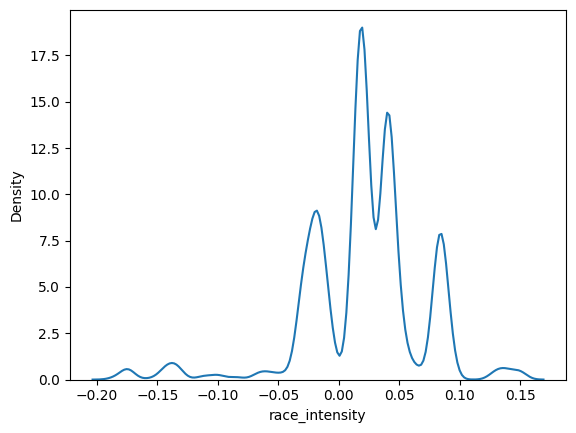

In [377]:
feature_of_interest = "race_intensity"
sns.kdeplot(interventional_explanations_df_dt, x=feature_of_interest)

In [378]:
number_quantiles = 40
quantiles_dt = interventional_explanations_df_dt["delta"].quantile([q / number_quantiles for q in (range(number_quantiles))])

print("Differences between quantiles:\n", quantiles_dt.diff())

Differences between quantiles:
 0.000         NaN
0.025    0.015097
0.050    0.002375
0.075    0.008614
0.100    0.038217
0.125    0.000617
0.150    0.001489
0.175    0.000458
0.200    0.000617
0.225    0.000000
0.250    0.000850
0.275    0.025747
0.300    0.029634
0.325    0.087865
0.350    0.002375
0.375    0.003328
0.400    0.003415
0.425    0.019163
0.450    0.007170
0.475    0.008200
0.500    0.008433
0.525    0.021014
0.550    0.220676
0.575    0.014768
0.600    0.003420
0.625    0.022913
0.650    0.023241
0.675    0.020304
0.700    0.027579
0.725    0.019223
0.750    0.009057
0.775    0.024554
0.800    0.038096
0.825    0.022928
0.850    0.019616
0.875    0.019938
0.900    0.017255
0.925    0.008379
0.950    0.007569
0.975    0.009532
Name: delta, dtype: float64


In [379]:
interested_explanations_dt = interventional_explanations_df_dt[feature_of_interest].values
quantile_of_interest_dt = quantiles_dt[0.550]

highly_impacted_instances_dt = np.argwhere(interested_explanations_dt <= quantile_of_interest_dt).squeeze()
moderately_impacted_instances_dt = np.array([i for i in range(interventional_explanations_dt.shape[0]) if i not in highly_impacted_instances_dt])

full_dataset.iloc[highly_impacted_instances_dt].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances_dt].describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='race_intensity', ylabel='Density'>

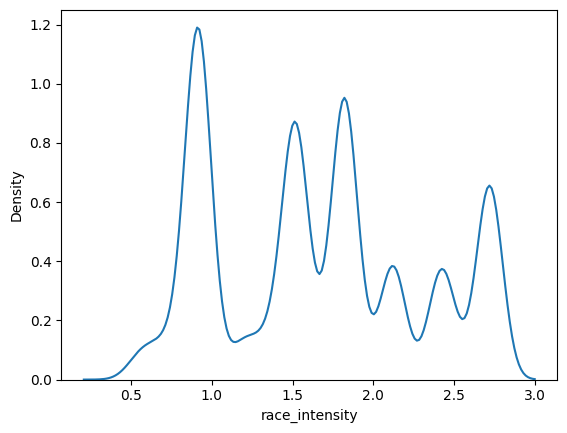

In [380]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_dt], x="race_intensity")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_dt], x="race_intensity")

<Axes: xlabel='climb_total', ylabel='Density'>

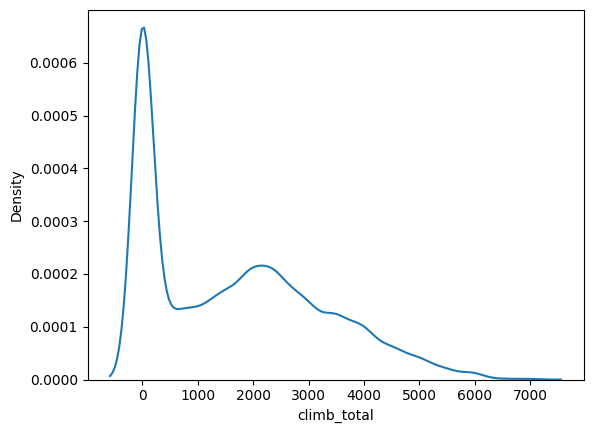

In [381]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_dt], x="climb_total")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_dt], x="climb_total")

Validation with classification report:

In [382]:
validation_dt = classification_report(test_target, dt.predict(test_feature), target_names=['Not Top 20', 'Top 20'],output_dict=True)
pd.DataFrame(validation_dt)

,Not Top 20,Top 20,accuracy,macro avg,weighted avg
precision,0.952687,0.331707,0.751342,0.642197,0.866046
recall,0.748178,0.770850,0.751342,0.759514,0.751342
f1-score,0.838138,0.463825,0.751342,0.650981,0.785912
support,30466.000000,4940.000000,0.751342,35406.000000,35406.000000


In [383]:
mean_absolute_importances_dt = interventional_explanations_df_dt.abs().mean()
features_by_importance_dt = interventional_explanations_df_dt.columns[mean_absolute_importances_dt.argsort()].tolist()
features_by_importance_dt

['points',
 'length',
 'cyclist_age',
 'profile',
 'cyclist_url',
 'season',
 'month',
 'is_tarmac',
 'nationality',
 'continent',
 'race_url',
 'startlist_quality',
 'bmi',
 'date',
 'race_intensity',
 'climb_total',
 'delta']

In [384]:
random_noise = np.random.rand(test_feature.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise_dt = dict()
for feature in features_by_importance_dt:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)] = test_feature.copy()
        corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude


validations_by_feature_and_noise_dt = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise_dt.items():
    validations_by_feature_and_noise_dt[(feature, noise)] = classification_report(test_target, dt.predict(corruption), target_names=['Not Top 20', 'Top 20'], output_dict=True)


metric = "f1-score"
corruption_validation_dt = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_dt[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise_dt
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_dt["difference"] = corruption_validation_dt["performance"] - validation_dt["weighted avg"][metric]
corruption_validation_dt

,feature,noise_magnitude,performance,algorithm,difference
0,points,0.1,0.785912,shap,0.000000
1,points,0.2,0.785912,shap,0.000000
2,points,0.3,0.785912,shap,0.000000
3,points,0.4,0.785912,shap,0.000000
4,points,0.5,0.785912,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,shap,0.000000
149,delta,0.6,0.786091,shap,0.000179
150,delta,0.7,0.786101,shap,0.000189
151,delta,0.8,0.786093,shap,0.000181


In [385]:
corruption_validation_dt.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                        count      mean       std       min       25%   
feature                                                                 
bmi                       9.0  0.785912  0.000000  0.785912  0.785912   
climb_total               9.0  0.785912  0.000000  0.785912  0.785912   
continent                 9.0  0.785912  0.000000  0.785912  0.785912   
cyclist_age               9.0  0.785912  0.000000  0.785912  0.785912   
cyclist_url               9.0  0.785912  0.000000  0.785912  0.785912   
date                      9.0  0.785912  0.000000  0.785912  0.785912   
delta                     9.0  0.785998  0.000103  0.785912  0.785912   
is_tarmac                 9.0  0.785912  0.000000  0.785912  0.785912   
length                    9.0  0.785912  0.000000  0.785912  0.785912   
month                     9.0  0.785912  0.000000  0.785912  0.785912   
nationality               9.0  0.785912  0.000000  0.785912  0.785912   
points                    9.0  0.785912  0.000000  0.785912  0.785912   
profile                   9.0  0.785912  0.000000  0.785912  0.785912   
race_intensity            9.0  0.776759  0.010185  0.759469  0.769544   
race_url                  9.0  0.785912  0.000000  0.785912  0.785912   
season                    9.0  0.785912  0.000000  0.785912  0.785912   
startlist_quality         9.0  0.785912  0.000000  0.785912  0.785912   

                                                difference            \
                        50%       75%       max      count      mean   
feature                                                                
bmi                0.785912  0.785912  0.785912        9.0  0.000000   
climb_total        0.785912  0.785912  0.785912        9.0  0.000000   
continent          0.785912  0.785912  0.785912        9.0  0.000000   
cyclist_age        0.785912  0.785912  0.785912        9.0  0.000000   
cyclist_url        0.785912  0.785912  0.785912        9.0  0.000000   
date               0.785912  0.785912  0.785912        9.0  0.000000   
delta              0.785912  0.786093  0.786138        9.0  0.000086   
is_tarmac          0.785912  0.785912  0.785912        9.0  0.000000   
length             0.785912  0.785912  0.785912        9.0  0.000000   
month              0.785912  0.785912  0.785912        9.0  0.000000   
nationality        0.785912  0.785912  0.785912        9.0  0.000000   
points             0.785912  0.785912  0.785912        9.0  0.000000   
profile            0.785912  0.785912  0.785912        9.0  0.000000   
race_intensity     0.778901  0.785828  0.787505        9.0 -0.009153   
race_url           0.785912  0.785912  0.785912        9.0  0.000000   
season             0.785912  0.785912  0.785912        9.0  0.000000   
startlist_quality  0.785912  0.785912  0.785912        9.0  0.000000   

                                                                               
                        std       min       25%       50%       75%       max  
feature                                                                        
bmi                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
climb_total        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
continent          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
cyclist_age        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
cyclist_url        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
date               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
delta              0.000103  0.000000  0.000000  0.000000  0.000181  0.000225  
is_tarmac          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
length             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
month              0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
nationality        0.000000  0.000000  0.000000  0.000000  0.000000  0.00000

In [386]:
corruption_validation_dt.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    17.0  0.786006  0.000386  0.785912  0.785912  0.785912   
0.2                    17.0  0.785969  0.000236  0.785912  0.785912  0.785912   
0.3                    17.0  0.785907  0.000020  0.785828  0.785912  0.785912   
0.4                    17.0  0.785650  0.001080  0.781459  0.785912  0.785912   
0.5                    17.0  0.785500  0.001700  0.778901  0.785912  0.785912   
0.6                    17.0  0.785387  0.002211  0.776808  0.785912  0.785912   
0.7                    17.0  0.784960  0.003973  0.769544  0.785912  0.785912   
0.8                    17.0  0.784659  0.005212  0.764433  0.785912  0.785912   
0.9                    17.0  0.784370  0.006417  0.759469  0.785912  0.785912   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.785912  0.787505       17.0  0.000094  0.000386  0.000000   
0.2              0.785912  0.786886       17.0  0.000057  0.000236  0.000000   
0.3              0.785912  0.785912       17.0 -0.000005  0.000020 -0.000084   
0.4              0.785912  0.785912       17.0 -0.000262  0.001080 -0.004453   
0.5              0.785912  0.785912       17.0 -0.000412  0.001700 -0.007011   
0.6              0.785912  0.786091       17.0 -0.000525  0.002211 -0.009104   
0.7              0.785912  0.786101       17.0 -0.000952  0.003973 -0.016368   
0.8              0.785912  0.786093       17.0 -0.001253  0.005212 -0.021479   
0.9              0.785912  0.786138       17.0 -0.001542  0.006417 -0.026443   

                                          
                 25%  50%  75%       max  
noise_magnitude                           
0.1              0.0  0.0  0.0  0.001592  
0.2              0.0  0.0  0.0  0.000974  
0.3              0.0  0.0  0.0  0.000000  
0.4              0.0  0.0  0.0  0.000000  
0.5              0.0  0.0  0.0  0.000000  
0.6              0.0  0.0  0.0  0.000179  
0.7              0.0  0.0  0.0  0.000189  
0.8              0.0  0.0  0.0  0.000181  
0.9              0.0  0.0  0.0  0.000225

#### Rule explanation

In [387]:
set_visualize_provider(InlineProvider())

explanation_algorithm_dt = LimeTabular(dt, train_feature)
lime_explanations_dt = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm_dt.explain_local(train_feature[:100], train_target[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 655360.00it/s]


In [388]:
metric = "f1-score"
corruption_validation_lime_dt = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_dt[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise_dt
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime_dt["difference"] = corruption_validation_lime_dt["performance"] - validation_dt["weighted avg"][metric]

corruption_validation_dt = pd.concat((corruption_validation_dt, corruption_validation_lime_dt))
corruption_validation_lime_dt

,feature,noise_magnitude,performance,algorithm,difference
0,points,0.1,0.785912,lime,0.000000
1,points,0.2,0.785912,lime,0.000000
2,points,0.3,0.785912,lime,0.000000
3,points,0.4,0.785912,lime,0.000000
4,points,0.5,0.785912,lime,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,lime,0.000000
149,delta,0.6,0.786091,lime,0.000179
150,delta,0.7,0.786101,lime,0.000189
151,delta,0.8,0.786093,lime,0.000181


In [389]:
corruption_validation_dt

,feature,noise_magnitude,performance,algorithm,difference
0,points,0.1,0.785912,shap,0.000000
1,points,0.2,0.785912,shap,0.000000
2,points,0.3,0.785912,shap,0.000000
3,points,0.4,0.785912,shap,0.000000
4,points,0.5,0.785912,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,lime,0.000000
149,delta,0.6,0.786091,lime,0.000179
150,delta,0.7,0.786101,lime,0.000189
151,delta,0.8,0.786093,lime,0.000181


#### Lore

In [390]:
explanation_algorithm_dt = LoreTabularExplainer(dt)
configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr": 0.1,
    "ngen": 100
}

lore_train = pd.concat((train_feature, train_target), axis="columns")
explanation_algorithm_dt.fit(lore_train, "top_20", config=configuration)
explanation_dt = explanation_algorithm_dt.explain(train_feature.iloc[0].values)

explanation_dt.getRules()

{'premise': [{'att': 'delta', 'op': '<=', 'thr': 27.5, 'is_continuous': True}],
 'cons': 1,
 'class_name': 'top_20'}

In [391]:
explanation_dt.getCounterfactualRules()

[{'premise': [{'att': 'delta', 'op': '>', 'thr': 28.5, 'is_continuous': True},
   {'att': 'race_intensity',
    'op': '<=',
    'thr': 2.4300519227981567,
    'is_continuous': True},
   {'att': 'race_intensity',
    'op': '>',
    'thr': 0.9419026672840118,
    'is_continuous': True},
   {'att': 'climb_total', 'op': '<=', 'thr': 3072.5, 'is_continuous': True},
   {'att': 'date', 'op': '>', 'thr': 1970.5, 'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '>',
    'thr': 904.5,
    'is_continuous': True},
   {'att': 'race_url', 'op': '<=', 'thr': 4732.0, 'is_continuous': True}],
  'cons': 0,
  'class_name': 'top_20'}]

In [392]:
explanation_dt.plotRules()

In [393]:
# Generate model rules
print("Model Rules:")
print(export_text(dt, feature_names=list(test_feature.columns)))

Model Rules:
|--- delta <= 261.50
|   |--- climb_total <= 3049.50
|   |   |--- race_intensity <= 0.96
|   |   |   |--- date <= 1995.50
|   |   |   |   |--- race_url <= 4240.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- race_url >  4240.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- date >  1995.50
|   |   |   |   |--- delta <= 131.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- delta >  131.50
|   |   |   |   |   |--- class: 0
|   |   |--- race_intensity >  0.96
|   |   |   |--- delta <= 27.50
|   |   |   |   |--- bmi <= 21.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- bmi >  21.53
|   |   |   |   |   |--- class: 1
|   |   |   |--- delta >  27.50
|   |   |   |   |--- race_intensity <= 2.42
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- race_intensity >  2.42
|   |   |   |   |   |--- class: 1
|   |--- climb_total >  3049.50
|   |   |--- race_intensity <= 2.26
|   |   |   |--- delta <= 67.50
|   |   |   |   |--- race_intensity <= 0.96
|   

#### Counterfactual instances

In [394]:
# need to convert data to the Dice format
dice_train_dataset = train_feature.copy()
dice_train_dataset["top_20"] = train_target
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model_dt = dice_ml.Model(
    model=dt,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

# the Dice object interfaces the counterfactual search
explanation_algorithm_dt = dice_ml.Dice(
    dice_dataset,
    dice_model_dt,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation_dt = explanation_algorithm_dt.generate_counterfactuals(
    dice_train_dataset.head(1).drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [395]:
explanation_dt.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,27.0,1,27.0,7.0,2,1.503613,0,46,22.256908,3,1



Diverse Counterfactual set (new outcome: 0)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,-,-,-,-,-,-,-,-,-,1064.5,-,-,-,-,-,-,-,0.0
1,4353.0,-,-,-,-,-,-,-,-,33631.1,-,-,-,-,-,-,-,0.0
2,-,61.3,-,-,-,-,-,-,-,20584.2,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,-,5907.5,-,-,-,-,53.0,-,-,0.0
4,-,-,-,-,-,-,-,-,-,41363.8,-,-,-,-,-,-,-,0.0
5,-,-,-,-,-,-,-,-,-,29076.3,-,-,-,-,-,-,-,0.0
6,-,-,-,-,-,-,-,-,-,410.2,-,-,-,-,-,-,-,0.0
7,-,-,-,-,-,-,-,-,-,7043.0,-,-,-,-,-,-,-,0.0
8,-,-,-,-,-,-,-,-,-,45009.9,-,-,-,3159.0,-,-,-,0.0
9,-,-,-,-,-,1667.0,-,-,-,36248.0,-,-,-,-,-,-,-,0.0


### Random Forest

In [396]:
# Import the model
rf = load('./models/random_forest.joblib')

#### Feature importance

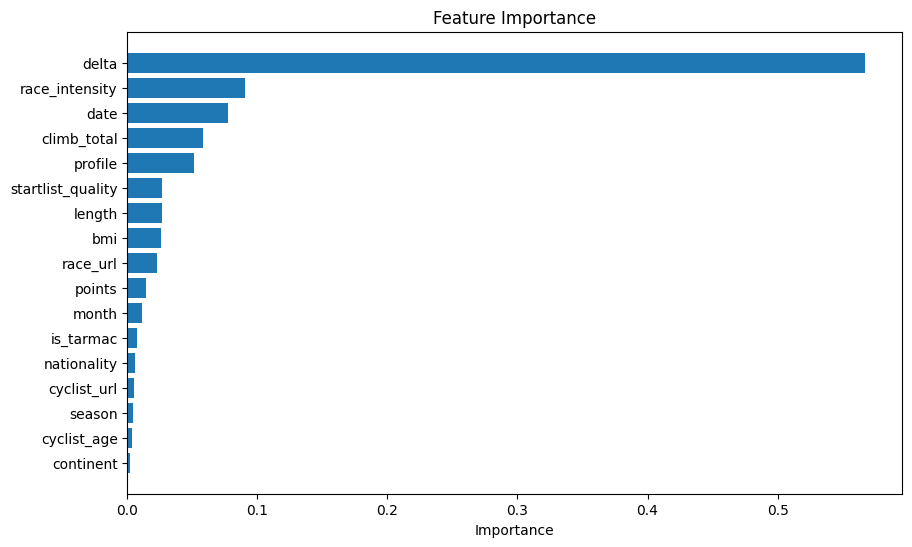

In [397]:
# Plot feature importance
plot_feature_importance(rf, test_feature.columns)

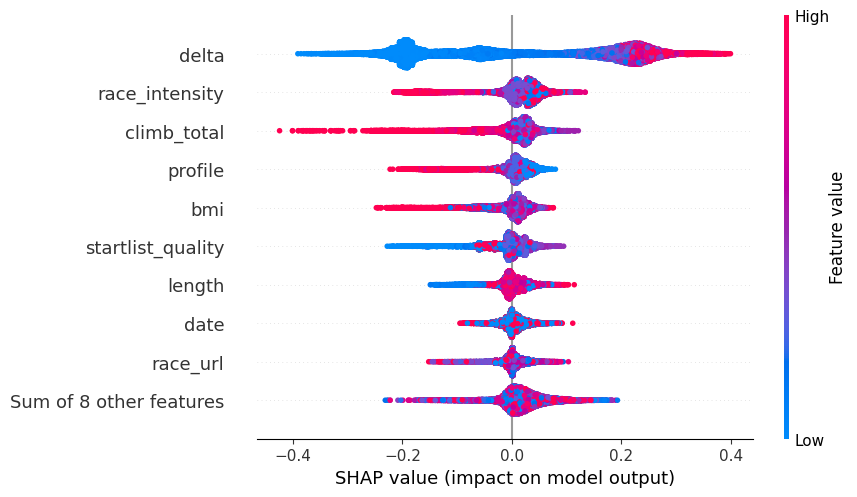

In [398]:
interventional_explanation_algorithm_rf = shap.TreeExplainer(
    model=rf,
    data=train_feature,         # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional",  # use a causal model
    approximate=True # use of approximation to speed up the computation
)

distributional_explanation_algorithm_rf = shap.TreeExplainer(
    model=rf,
    feature_perturbation="tree_path_dependent", # condition on the distribution learned on the train data
    approximate=True # use of approximation to speed up the computation
)

interventional_explanations_rf = interventional_explanation_algorithm_rf(test_feature)
distributional_explanations_rf = distributional_explanation_algorithm_rf(test_feature)

shap.plots.beeswarm(interventional_explanations_rf[:, :, 0])

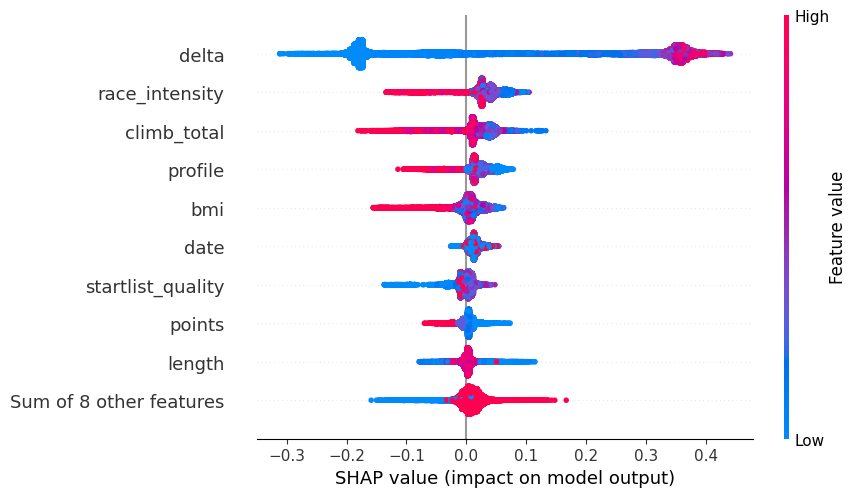

In [399]:
shap.plots.beeswarm(distributional_explanations_rf[:, :, 0])

<Axes: ylabel='Density'>

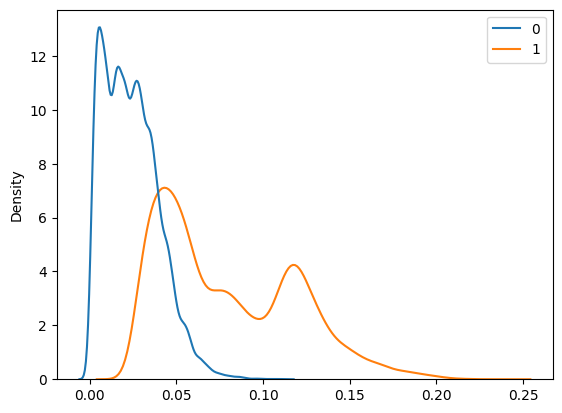

In [400]:
explanation_differences_rf = interventional_explanations_rf.values - distributional_explanations_rf.values

maximum_differences_per_instance_rf = explanation_differences_rf.max(axis=1)
sns.kdeplot(maximum_differences_per_instance_rf)

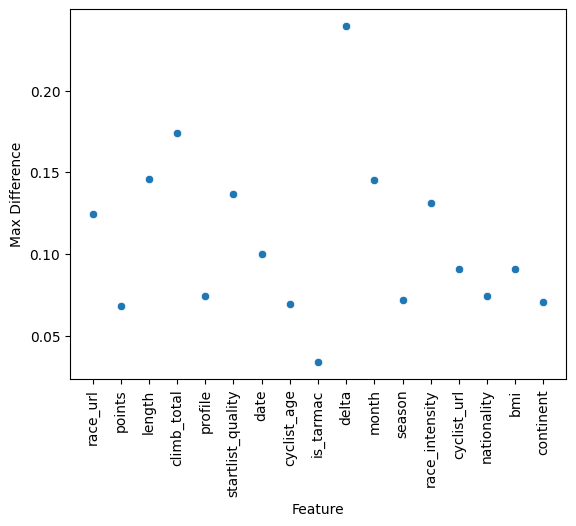

In [401]:
maximum_differences_per_feature_rf = explanation_differences_rf.max(axis=0)

feature_importances_rf = pd.DataFrame({
    'Feature': columns,
    'Max Difference': maximum_differences_per_feature_rf.max(axis=1)
})

sns.scatterplot(x='Feature', y='Max Difference', data=feature_importances_rf)
plt.xticks(rotation=90)
plt.show()

In [402]:
interventional_explanations_df_rf = pd.DataFrame(interventional_explanations_rf[:, :, 0].values, columns=columns)
interventional_explanations_df_rf.describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,0.003165,-0.000549,0.001122,-0.000341,0.001714,-0.003930,0.003920,0.003683,0.000406,0.030327,-0.000697,0.000327,0.012035,0.009490,0.002781,-0.003946,0.003088
std,0.019631,0.016121,0.025817,0.048480,0.040901,0.033609,0.020161,0.012099,0.013526,0.184614,0.011469,0.007276,0.048850,0.013693,0.010568,0.037996,0.008389
min,-0.151960,-0.067184,-0.149042,-0.424586,-0.222570,-0.227758,-0.094870,-0.051742,-0.109997,-0.391113,-0.135198,-0.047344,-0.215441,-0.072910,-0.058790,-0.247725,-0.062883
25%,-0.005262,-0.005549,-0.008828,-0.009209,-0.002599,-0.012809,-0.006439,-0.002387,0.000915,-0.169559,-0.004973,-0.002865,0.003708,0.000171,-0.002562,-0.012555,-0.000115
50%,0.001630,0.000906,-0.000571,0.012713,0.009276,0.001011,0.002394,0.000887,0.001572,0.020520,0.000028,0.000427,0.021390,0.006438,0.001245,0.006786,0.001214
75%,0.011843,0.005758,0.014326,0.026430,0.024100,0.016271,0.014434,0.009888,0.003757,0.211667,0.004897,0.003073,0.037733,0.016749,0.008376,0.018124,0.007000
max,0.103515,0.089725,0.114209,0.121615,0.079710,0.094758,0.111418,0.065997,0.031593,0.399734,0.069388,0.050806,0.134191,0.083771,0.067660,0.075995,0.046559


<Axes: xlabel='race_intensity', ylabel='Density'>

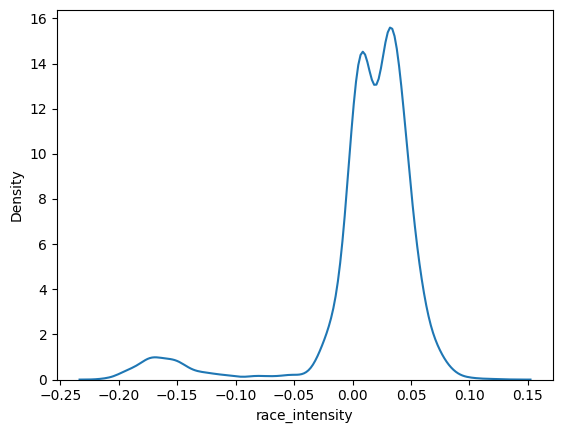

In [403]:
feature_of_interest = "race_intensity"
sns.kdeplot(interventional_explanations_df_rf, x=feature_of_interest)

In [404]:
number_quantiles = 40
quantiles_rf = interventional_explanations_df["delta"].quantile([q / number_quantiles for q in (range(number_quantiles))])

print("Differences between quantiles:\n", quantiles_rf.diff())

Differences between quantiles:
 0.000         NaN
0.025    0.150582
0.050    0.019894
0.075    0.009787
0.100    0.007765
0.125    0.004428
0.150    0.004026
0.175    0.004081
0.200    0.004251
0.225    0.005930
0.250    0.010811
0.275    0.017545
0.300    0.025731
0.325    0.022759
0.350    0.022876
0.375    0.014770
0.400    0.010483
0.425    0.011687
0.450    0.014105
0.475    0.019894
0.500    0.030228
0.525    0.042694
0.550    0.050378
0.575    0.026538
0.600    0.017040
0.625    0.012949
0.650    0.011077
0.675    0.009702
0.700    0.007712
0.725    0.006825
0.750    0.006233
0.775    0.006275
0.800    0.005269
0.825    0.005441
0.850    0.005320
0.875    0.005965
0.900    0.006470
0.925    0.008032
0.950    0.011171
0.975    0.019173
Name: delta, dtype: float64


In [405]:
interested_explanations_rf = interventional_explanations_df_rf[feature_of_interest].values
quantile_of_interest_rf = quantiles_rf[0.025]


highly_impacted_instances_rf = np.argwhere(interested_explanations_rf <= quantile_of_interest_rf).squeeze()
moderately_impacted_instances_rf = np.array([i for i in range(interventional_explanations_rf.shape[0]) if i not in highly_impacted_instances_rf])

full_dataset.iloc[highly_impacted_instances_rf].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances_rf].describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='race_intensity', ylabel='Density'>

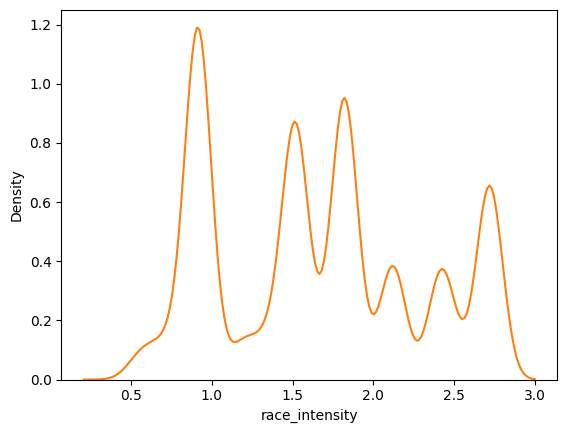

In [406]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_rf], x="race_intensity")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_rf], x="race_intensity")

<Axes: xlabel='climb_total', ylabel='Density'>

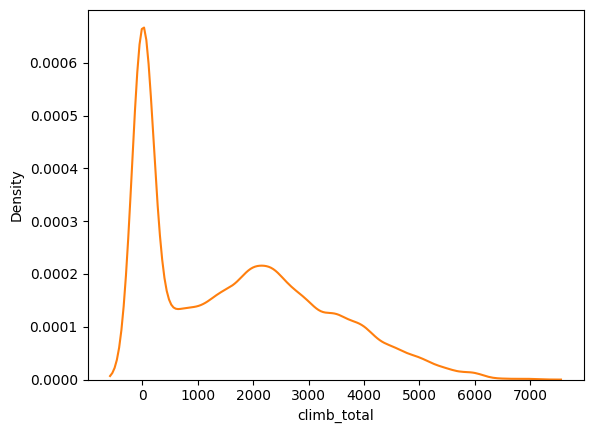

In [407]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_rf], x="climb_total")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_rf], x="climb_total")

Validation with classification report:

In [408]:
validation_rf = classification_report(test_target, rf.predict(test_feature), target_names=['Not Top 20', 'Top 20'],output_dict=True)
pd.DataFrame(validation_rf)

,Not Top 20,Top 20,accuracy,macro avg,weighted avg
precision,0.958560,0.399238,0.805231,0.678899,0.880521
recall,0.808606,0.784413,0.805231,0.796510,0.805231
f1-score,0.877221,0.529155,0.805231,0.703188,0.828657
support,30466.000000,4940.000000,0.805231,35406.000000,35406.000000


In [409]:
mean_absolute_importances_rf = interventional_explanations_df_rf.abs().mean()
features_by_importance_rf = interventional_explanations_df_rf.columns[mean_absolute_importances_rf.argsort()].tolist()
features_by_importance_rf

['season',
 'continent',
 'is_tarmac',
 'month',
 'nationality',
 'cyclist_age',
 'points',
 'cyclist_url',
 'race_url',
 'date',
 'length',
 'startlist_quality',
 'bmi',
 'profile',
 'climb_total',
 'race_intensity',
 'delta']

In [410]:
random_noise = np.random.rand(test_feature.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise_rf = dict()
for feature in features_by_importance_rf:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)] = test_feature.copy()
        corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude


validations_by_feature_and_noise_rf = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise_rf.items():
    validations_by_feature_and_noise_rf[(feature, noise)] = classification_report(test_target, rf.predict(corruption), target_names=['Not Top 20', 'Top 20'], output_dict=True)


metric = "f1-score"
corruption_validation_rf = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_rf[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise_rf
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_rf["difference"] = corruption_validation_rf["performance"] - validation_rf["weighted avg"][metric]
corruption_validation_rf

,feature,noise_magnitude,performance,algorithm,difference
0,season,0.1,0.828657,shap,0.000000
1,season,0.2,0.828657,shap,0.000000
2,season,0.3,0.828657,shap,0.000000
3,season,0.4,0.828657,shap,0.000000
4,season,0.5,0.828657,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828680,shap,0.000022
149,delta,0.6,0.828546,shap,-0.000111
150,delta,0.7,0.828491,shap,-0.000166
151,delta,0.8,0.828519,shap,-0.000139


In [411]:
corruption_validation_rf.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                        count      mean       std       min       25%   
feature                                                                 
bmi                       9.0  0.825962  0.001540  0.823533  0.824904   
climb_total               9.0  0.828657  0.000000  0.828657  0.828657   
continent                 9.0  0.828825  0.000211  0.828657  0.828657   
cyclist_age               9.0  0.828685  0.000050  0.828654  0.828657   
cyclist_url               9.0  0.828629  0.000012  0.828608  0.828635   
date                      9.0  0.828657  0.000000  0.828657  0.828657   
delta                     9.0  0.828612  0.000082  0.828491  0.828546   
is_tarmac                 9.0  0.828726  0.000094  0.828657  0.828657   
length                    9.0  0.828657  0.000000  0.828657  0.828657   
month                     9.0  0.828533  0.000168  0.828247  0.828402   
nationality               9.0  0.828680  0.000040  0.828657  0.828657   
points                    9.0  0.828657  0.000000  0.828657  0.828657   
profile                   9.0  0.824208  0.005783  0.814648  0.819332   
race_intensity            9.0  0.806352  0.011593  0.788285  0.798095   
race_url                  9.0  0.828667  0.000012  0.828657  0.828657   
season                    9.0  0.828581  0.000095  0.828426  0.828515   
startlist_quality         9.0  0.828657  0.000000  0.828657  0.828657   

                                                difference            \
                        50%       75%       max      count      mean   
feature                                                                
bmi                0.826274  0.826966  0.828037        9.0 -0.002695   
climb_total        0.828657  0.828657  0.828657        9.0  0.000000   
continent          0.828657  0.828992  0.829160        9.0  0.000167   
cyclist_age        0.828657  0.828693  0.828799        9.0  0.000028   
cyclist_url        0.828635  0.828635  0.828635        9.0 -0.000028   
date               0.828657  0.828657  0.828657        9.0  0.000000   
delta              0.828680  0.828680  0.828680        9.0 -0.000045   
is_tarmac          0.828657  0.828762  0.828889        9.0  0.000069   
length             0.828657  0.828657  0.828657        9.0  0.000000   
month              0.828657  0.828657  0.828657        9.0 -0.000125   
nationality        0.828657  0.828674  0.828770        9.0  0.000023   
points             0.828657  0.828657  0.828657        9.0  0.000000   
profile            0.828657  0.828657  0.828657        9.0 -0.004450   
race_intensity     0.807239  0.816731  0.821351        9.0 -0.022306   
race_url           0.828657  0.828680  0.828680        9.0  0.000010   
season             0.828657  0.828657  0.828657        9.0 -0.000076   
startlist_quality  0.828657  0.828657  0.828657        9.0  0.000000   

                                                                               
                        std       min       25%       50%       75%       max  
feature                                                                        
bmi                0.001540 -0.005124 -0.003753 -0.002383 -0.001692 -0.000621  
climb_total        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
continent          0.000211  0.000000  0.000000  0.000000  0.000335  0.000502  
cyclist_age        0.000050 -0.000004  0.000000  0.000000  0.000035  0.000141  
cyclist_url        0.000012 -0.000050 -0.000022 -0.000022 -0.000022 -0.000022  
date               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
delta              0.000082 -0.000166 -0.000111  0.000022  0.000022  0.000022  
is_tarmac          0.000094  0.000000  0.000000  0.000000  0.000105  0.000231  
length             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
month              0.000168 -0.000411 -0.000255  0.000000  0.000000  0.000000  
nationality        0.000040  0.000000  0.000000  0.000000  0.000017  0.00011

In [412]:
corruption_validation_rf.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    17.0  0.828191  0.001769  0.821351  0.828657  0.828657   
0.2                    17.0  0.827925  0.002741  0.817341  0.828657  0.828657   
0.3                    17.0  0.827856  0.002896  0.816731  0.828657  0.828657   
0.4                    17.0  0.827540  0.004104  0.811732  0.828657  0.828657   
0.5                    17.0  0.827257  0.005191  0.807239  0.828657  0.828657   
0.6                    17.0  0.826738  0.006047  0.803867  0.828546  0.828657   
0.7                    17.0  0.826084  0.007594  0.798095  0.828491  0.828657   
0.8                    17.0  0.825580  0.009027  0.792526  0.828470  0.828657   
0.9                    17.0  0.825166  0.010142  0.788285  0.828426  0.828657   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.828657  0.828680       17.0 -0.000466  0.001769 -0.007306   
0.2              0.828657  0.828680       17.0 -0.000732  0.002741 -0.011317   
0.3              0.828657  0.828680       17.0 -0.000801  0.002896 -0.011926   
0.4              0.828657  0.828680       17.0 -0.001117  0.004104 -0.016926   
0.5              0.828657  0.828680       17.0 -0.001400  0.005191 -0.021419   
0.6              0.828657  0.828892       17.0 -0.001919  0.006047 -0.024790   
0.7              0.828664  0.828992       17.0 -0.002574  0.007594 -0.030562   
0.8              0.828680  0.829093       17.0 -0.003078  0.009027 -0.036132   
0.9              0.828680  0.829160       17.0 -0.003491  0.010142 -0.040372   

                                                    
                      25%  50%       75%       max  
noise_magnitude                                     
0.1              0.000000  0.0  0.000000  0.000022  
0.2              0.000000  0.0  0.000000  0.000022  
0.3              0.000000  0.0  0.000000  0.000022  
0.4              0.000000  0.0  0.000000  0.000022  
0.5              0.000000  0.0  0.000000  0.000022  
0.6             -0.000111  0.0  0.000000  0.000234  
0.7             -0.000166  0.0  0.000007  0.000335  
0.8             -0.000187  0.0  0.000022  0.000436  
0.9             -0.000231  0.0  0.000022  0.000502

#### Rule explanation

In [413]:
set_visualize_provider(InlineProvider())

explanation_algorithm_rf = LimeTabular(rf, train_feature)
lime_explanations_rf = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm_rf.explain_local(train_feature[:100], train_target[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 625082.56it/s]


In [414]:
metric = "f1-score"
corruption_validation_lime_rf = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_rf[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise_rf
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime_rf["difference"] = corruption_validation_lime_rf["performance"] - validation_rf["weighted avg"][metric]

corruption_validation_rf = pd.concat((corruption_validation_rf, corruption_validation_lime_rf))
corruption_validation_lime_rf

,feature,noise_magnitude,performance,algorithm,difference
0,season,0.1,0.828657,lime,0.000000
1,season,0.2,0.828657,lime,0.000000
2,season,0.3,0.828657,lime,0.000000
3,season,0.4,0.828657,lime,0.000000
4,season,0.5,0.828657,lime,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828680,lime,0.000022
149,delta,0.6,0.828546,lime,-0.000111
150,delta,0.7,0.828491,lime,-0.000166
151,delta,0.8,0.828519,lime,-0.000139


In [415]:
corruption_validation_rf

,feature,noise_magnitude,performance,algorithm,difference
0,season,0.1,0.828657,shap,0.000000
1,season,0.2,0.828657,shap,0.000000
2,season,0.3,0.828657,shap,0.000000
3,season,0.4,0.828657,shap,0.000000
4,season,0.5,0.828657,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828680,lime,0.000022
149,delta,0.6,0.828546,lime,-0.000111
150,delta,0.7,0.828491,lime,-0.000166
151,delta,0.8,0.828519,lime,-0.000139


Lore

In [416]:
## COMMENTATO PERCHE' CI METTE 10 MINUTI MA FUNZIONA

# explanation_algorithm_rf = LoreTabularExplainer(rf)
# configuration = {
#     "neigh_type": "rndgen",
#     "size": 1000,
#     "ocr": 0.1,
#     "ngen": 100
# }

# lore_train = pd.concat((train_feature, train_target), axis="columns")
# explanation_algorithm_rf.fit(lore_train, "top_20", config=configuration)
# explanation_rf = explanation_algorithm_rf.explain(train_feature.iloc[0].values)

# explanation_rf.getRules()

In [417]:
# explanation_rf.getCounterfactualRules()

In [418]:
# explanation_rf.plotRules()

##### Counterfactual instances

In [419]:
dice_model_rf = dice_ml.Model(
    model=rf,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

# the Dice object interfaces the counterfactual search
explanation_algorithm_rf = dice_ml.Dice(
    dice_dataset,
    dice_model_rf,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation_rf = explanation_algorithm_rf.generate_counterfactuals(
    dice_train_dataset.head(1).drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


In [420]:
explanation_rf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,27.0,1,27.0,7.0,2,1.503613,0,46,22.256908,3,1



Diverse Counterfactual set (new outcome: 0)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,20.280706,-,0.0
1,-,-,-,-,-,907.6,-,-,-,-,-,-,-,-,-,-,5.0,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,4013.0,-,19.85591,-,0.0
3,-,-,-,-,-,-,-,-,-,23066.0,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,71.0,-,-,0.0
5,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,20.082616,-,0.0
6,-,-,-,-,-,-,-,46.2,-,49238.2,-,-,-,-,-,-,-,0.0
7,-,-,-,-,-,-,-,-,-,48592.4,-,-,-,-,-,-,-,0.0
8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,52.0,27.739223,-,0.0
9,-,-,-,-,-,-,-,52.2,-,20111.4,-,-,-,-,-,-,-,0.0


### AdaBoost

In [421]:
# Import the models
clf = load('./models/adaboost.joblib')
clf2 = load('./models/adaboost2.joblib')

#### Feature importance

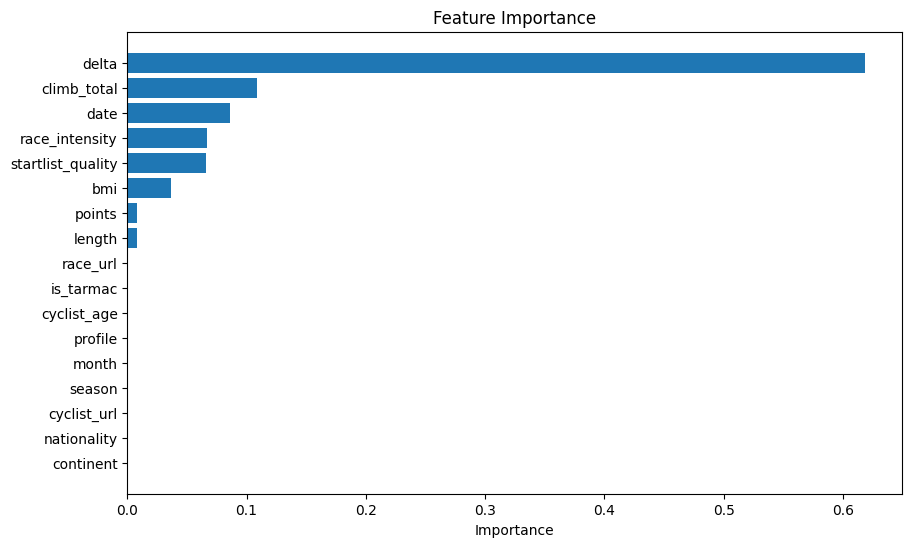

In [422]:
# Plot feature importance
plot_feature_importance(clf, test_feature.columns)

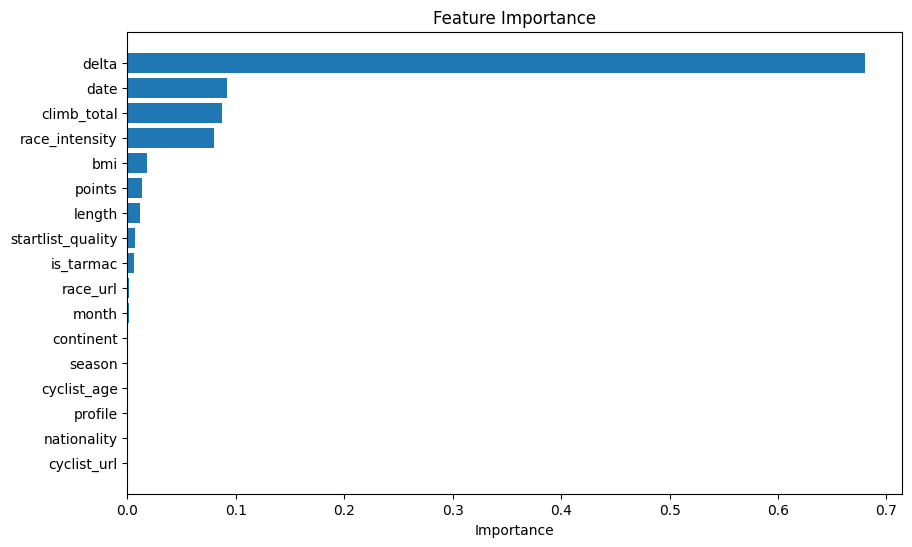

In [423]:
# Plot feature importance
plot_feature_importance(clf2, test_feature.columns)

NameError: name 'data' is not defined

In [ ]:
shap.plots.beeswarm(distributional_explanations_clf[:, :, 0])

In [ ]:
interventional_explanation_algorithm_clf2 = shap.TreeExplainer(
    model=clf2,
    data=train_feature,         # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional",  # use a causal model
    approximate=True # use of approximation to speed up the computation
)

distributional_explanation_algorithm_clf2 = shap.TreeExplainer(
    model=clf2,
    feature_perturbation="tree_path_dependent", # condition on the distribution learned on the train data
    approximate=True # use of approximation to speed up the computation
)

interventional_explanations_clf2 = interventional_explanation_algorithm_clf2(test_feature)
distributional_explanations_clf2 = distributional_explanation_algorithm_clf2(test_feature)

shap.plots.beeswarm(interventional_explanations_clf2[:, :, 0])

In [ ]:
shape.plots.beeswarm(distributional_explanations_clf2[:, :, 0])

### Naïve Bayes

In [424]:
# Import the model
gnb = load('./models/naive_bayes.joblib')

#### Feature importance

Permutation Importance:
              Feature  Importance       Std
1              points    0.007776  0.000053
15                bmi    0.000923  0.000262
9               delta    0.000367  0.001117
11             season    0.000132  0.000127
14        nationality    0.000094  0.000048
8           is_tarmac    0.000075  0.000013
16          continent    0.000028  0.000128
6                date   -0.000075  0.000067
13        cyclist_url   -0.000217  0.000081
7         cyclist_age   -0.000348  0.000632
0            race_url   -0.001742  0.000186
12     race_intensity   -0.002504  0.000196
10              month   -0.004481  0.000450
2              length   -0.009791  0.000528
5   startlist_quality   -0.009829  0.000740
4             profile   -0.012286  0.000340
3         climb_total   -0.023678  0.000451


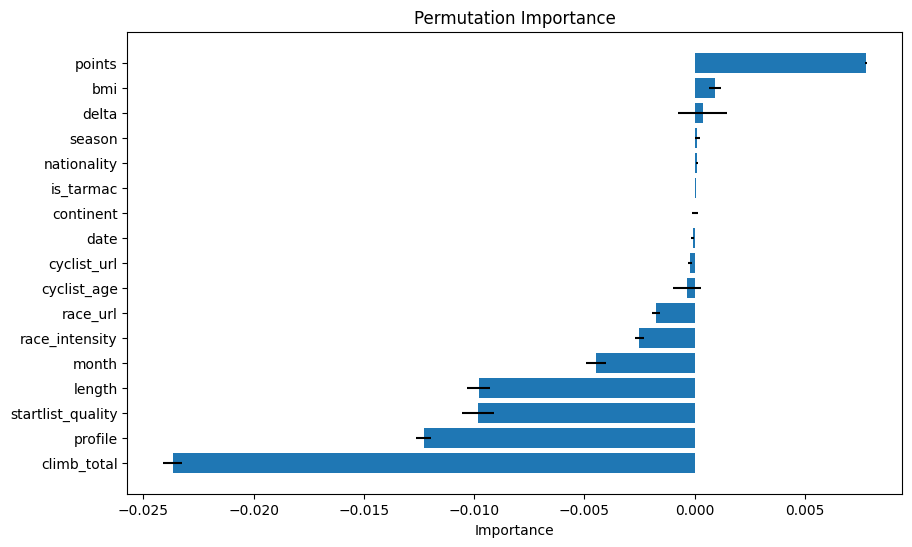

,Feature,Importance,Std
1,points,0.007776,0.000053
15,bmi,0.000923,0.000262
9,delta,0.000367,0.001117
11,season,0.000132,0.000127
14,nationality,0.000094,0.000048
8,is_tarmac,0.000075,0.000013
16,continent,0.000028,0.000128
6,date,-0.000075,0.000067
13,cyclist_url,-0.000217,0.000081
7,cyclist_age,-0.000348,0.000632


In [425]:
# Compute permutation importance
compute_permutation_importance(gnb, x_test, y_test)

#### Rules explanation

### K-Nearest Neighbors (KNN)

In [427]:
# Import the model
knn = load('./models/knn.joblib')

#### Feature importance

### Neural Network

In [429]:
# Import the model
NN_model = load_model('./models/neural_network.keras')

#### Feature importance